Documentos temáticos considerados: 117
Vocabulário candidato (top 300): 300 termos
Total de janelas: 105132
Termos com presença em janelas: 300
Termos selecionados para o heatmap (máx 50): 50
['abolição', 'acusado', 'acórdão', 'ameaça', 'armada', 'associação', 'atos', 'ação', 'caso', 'conduta', 'conforme', 'contra', 'crime', 'criminosa', 'código', 'dano', 'defesa', 'delito', 'democrático', 'denunciado', 'denúncia', 'direito', 'emprego', 'estado', 'exercício', 'fato', 'federal', 'geral', 'golpe', 'governo', 'grave', 'grupo', 'ministro', 'palacio_do_planalto', 'patrimônio', 'pessoa', 'poder', 'prejuízo', 'presente', 'processo', 'prova', 'prática', 'público', 'relação', 'república', 'réu', 'supremo_tribunal_federal', 'união', 'violencia', 'voto']
Matriz PPMI normalizada salva em: /Users/cibelealexandreu/Documents/jurimetria_aved_stf/outputs/tables/ppmi_matrix.csv


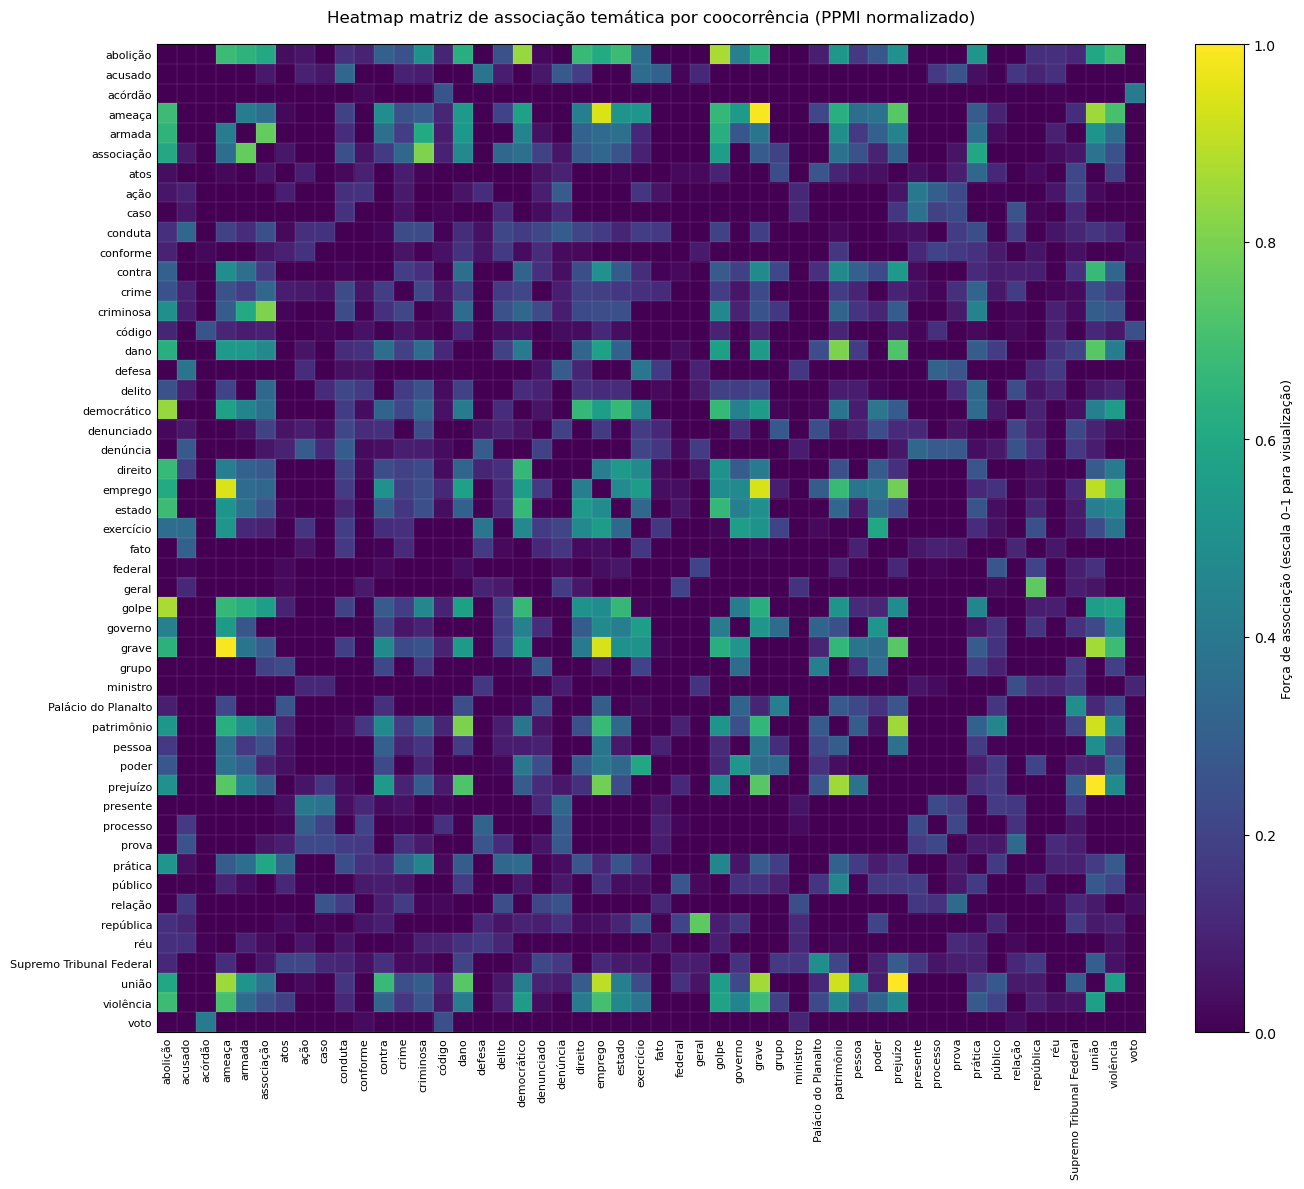

Heatmap salvo em: /Users/cibelealexandreu/Documents/jurimetria_aved_stf/outputs/figures/semantic_similarity_matrix.png


In [8]:
from pathlib import Path
import json
import re
from collections import Counter
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

config_path = (
    Path.home()
    / "Documents"
    / "jurimetria_aved_stf"
    / "config"
    / "project_config.json"
)
config = json.loads(config_path.read_text(encoding="utf-8"))

thematic_dir = Path(config["paths"]["thematic_dir"])
figures_dir  = Path(config["paths"]["figures_dir"])
logs_dir     = Path(config["paths"]["logs_dir"])
tables_dir   = Path(config["paths"]["tables_dir"])

figures_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)
tables_dir.mkdir(parents=True, exist_ok=True)

phrase_map = {
    "supremo tribunal federal": "supremo_tribunal_federal",
    "palacio do planalto": "palacio_do_planalto",
    "palácio do planalto": "palacio_do_planalto",
    "praca dos tres poderes": "praca_dos_tres_poderes",
    "praça dos tres poderes": "praca_dos_tres_poderes",
    "praça dos três poderes": "praca_dos_tres_poderes",
    "redes sociais": "redes_sociais",
    "rede social": "rede_social",
    "extrema direita": "extrema_direita",
    "atos antidemocraticos": "atos_antidemocraticos",
    "ato antidemocratico": "atos_antidemocraticos",
}

base_stopwords = {
    "a","o","os","as","de","da","do","das","dos","em","no","na","nos","nas",
    "para","por","com","ao","aos","à","às",
    "um","uma","uns","umas","que","se",
    "seu","sua","seus","suas",
    "é","era","foi","são","ser","há","houve","ter","tendo",
    "como","mais","menos",
    "tambem","também",
    "muito","muitos","muita","muitas",
    "pouco","poucos","sobre","entre",
    "ate","até","apos","após","antes",
    "e","ou","mas","porque","pois","quando","onde",
    "qual","quais","cujo","cuja","cujos","cujas",
    "este","esta","estes","estas","isso","isto",
    "aquele","aquela","aqueles","aquelas",
    "cada","seja","foram","serao","será","serão","sido",
    "diante","perante",
    "mesmo","mesma","mesmos","mesmas",
    "todo","toda","todos","todas",
    "entao","então","assim",
    "aqui","ali","la","lá",
    "ai","aí","me","pra","es","né","você","voce",
    "quem","tenha","meu","eu",
    "tudo","data","entretanto","então",
    "ainda","bem","corte","dia","iii","lei","parágrafo","paragrafo",
    "penal","pena","teor","vogal",
    "forma","inteiro","artigo","auto","único","unico","sob","outro",
    "não","nao",
    "pelo","pela",
}

noise_terms = {
    "http","https","portal","pagina","página",
    "autenticacao","autenticação","autenticardocumento",
    "senha","cpf","cnpj","pdf","doc","fls","fl","art",
    "jus","min","rapj"
}

names_manual = {
    "maria","carlos","thiago","rodolfo","arnold","bremer","nunes","raimundo",
    "marques","procopio","procópio","christina","alex","ricardo","medeiros",
    "cornelio","cornélio","lima","cunha","girardi","assis","adriano","ribeiro",
    "lilian","souza","cesar","césar","henrique","costa","mathar","santos",
    "chagas","pereira","alexandre","moraes","morae"
}

institucional_ruido = set()

stop_all = base_stopwords | noise_terms | names_manual | institucional_ruido

lemma_map = {
    "podere": "poder",
    "violencias": "violencia",
    "violência": "violencia",
    "violento": "violencia",
    "violenta": "violencia",
    "violentos": "violencia",
    "violentas": "violencia",
}

def apply_phrases(text: str) -> str:
    t = text.lower()
    for p, rep in phrase_map.items():
        t = re.sub(r"\b" + re.escape(p) + r"\b", rep, t, flags=re.IGNORECASE)
    return t

def normalize_plural(token: str) -> str:
    if "_" not in token and len(token) >= 5 and token.endswith("s"):
        return token[:-1]
    return token

def clean_token(raw: str):
    w = raw.lower()

    if re.search(r"(.)\1\1\1", w):
        return None

    w = normalize_plural(w)
    w = lemma_map.get(w, w)

    if len(w) < 3:
        return None
    if w.isdigit():
        return None
    if w in stop_all:
        return None

    return w

def tokenize(text: str):
    t = apply_phrases(text)
    t = re.sub(r"https?://\S+", " ", t)
    t = re.sub(r"\b(página|pagina)\b\s*\d+", " ", t, flags=re.IGNORECASE)
    t = re.sub(r"[^\wáéíóúâêôãõçüÁÉÍÓÚÂÊÔÃÕÇÜ]+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()

    toks = []
    for raw in t.split():
        w = clean_token(raw)
        if w is not None:
            toks.append(w)

    return toks

def pretty_label(token: str) -> str:
    custom = {
        "palacio_do_planalto": "Palácio do Planalto",
        "praca_dos_tres_poderes": "Praça dos Três Poderes",
        "fake_news": "fake news",
        "extrema_direita": "extrema direita",
        "redes_sociais": "redes sociais",
        "rede_social": "rede social",
        "atos_antidemocraticos": "atos antidemocráticos",
        "supremo_tribunal_federal": "Supremo Tribunal Federal",
        "violencia": "violência",
    }
    if token in custom:
        return custom[token]
    return token.replace("_", " ")

thematic_files = sorted(thematic_dir.glob("*.txt"))
docs_tokens = []

for p in thematic_files:
    txt = p.read_text(encoding="utf-8", errors="ignore")
    toks = tokenize(txt)
    if len(toks) >= 20:
        docs_tokens.append(toks)

n_docs = len(docs_tokens)
print(f"Documentos temáticos considerados: {n_docs}")

if n_docs == 0:
    raise SystemExit("Nenhum documento temático utilizável após limpeza.")

WINDOW = 50
STEP = 25
TOP_VOCAB = 300
MIN_TERM_WIN = 3
MIN_PAIR_WIN = 2
TOP_TERMS = 50

term_global = Counter()
for toks in docs_tokens:
    term_global.update(toks)

vocab_candidates = {t for t, _ in term_global.most_common(TOP_VOCAB)}
print(f"Vocabulário candidato (top {TOP_VOCAB}): {len(vocab_candidates)} termos")

term_in_windows = Counter()
pair_in_windows = Counter()
total_windows = 0

for toks in docs_tokens:
    n = len(toks)
    if n <= WINDOW:
        windows = [toks]
    else:
        windows = [
            toks[i:i+WINDOW]
            for i in range(0, n - WINDOW + 1, STEP)
        ]

    for w in windows:
        total_windows += 1
        uniq = sorted(set(t for t in w if t in vocab_candidates))
        if len(uniq) < 2:
            continue

        for t in uniq:
            term_in_windows[t] += 1

        for i in range(len(uniq)):
            for j in range(i + 1, len(uniq)):
                pair_in_windows[(uniq[i], uniq[j])] += 1

print(f"Total de janelas: {total_windows}")
print(f"Termos com presença em janelas: {len(term_in_windows)}")

if total_windows == 0:
    raise SystemExit("Nenhuma janela formada. Verifique o corpus temático.")

candidate_terms = [
    t for t, c in term_in_windows.items()
    if c >= MIN_TERM_WIN
]

def has_enough_pairs(t: str) -> bool:
    for (a, b), v in pair_in_windows.items():
        if v >= MIN_PAIR_WIN and (a == t or b == t):
            return True
    return False

candidate_terms = [t for t in candidate_terms if has_enough_pairs(t)]

if not candidate_terms:
    print("Nenhum termo passou pelos thresholds. Usando fallback com termos mais frequentes nas janelas.")
    candidate_terms = [t for t, _ in term_in_windows.most_common(TOP_TERMS)]

importance = Counter()
for (a, b), v in pair_in_windows.items():
    if v >= MIN_PAIR_WIN and a in candidate_terms and b in candidate_terms:
        importance[a] += v
        importance[b] += v

if not importance:
    print("Nenhum par relevante encontrado. Usando fallback com termos mais frequentes nas janelas.")
    importance = Counter(dict(term_in_windows.most_common(TOP_TERMS)))

top_terms = [t for t, _ in importance.most_common(TOP_TERMS)]
top_terms = sorted(set(top_terms))
V = len(top_terms)

print(f"Termos selecionados para o heatmap (máx 50): {V}")
print(top_terms)

if V < 2:
    raise SystemExit("Termos insuficientes para montar heatmap.")

total_windows_f = float(total_windows)
p_term = {
    t: (term_in_windows[t] / total_windows_f)
    for t in top_terms
}

ppmi_matrix = np.zeros((V, V), dtype=float)

for i, ti in enumerate(top_terms):
    for j, tj in enumerate(top_terms):
        if j <= i:
            continue
        c_ij = pair_in_windows.get((ti, tj), 0)
        if c_ij < MIN_PAIR_WIN:
            continue
        p_ij = c_ij / total_windows_f
        if p_ij <= 0:
            continue
        denom = p_term[ti] * p_term[tj]
        if denom <= 0:
            continue
        val = math.log2(p_ij / denom)
        if val > 0:
            ppmi_matrix[i, j] = val
            ppmi_matrix[j, i] = val

if np.all(ppmi_matrix == 0):
    print("Todos os valores de PPMI foram zero; usando coocorrência normalizada.")
    max_co = max(pair_in_windows.values()) if pair_in_windows else 1
    for i, ti in enumerate(top_terms):
        for j, tj in enumerate(top_terms):
            if j <= i:
                continue
            c_ij = pair_in_windows.get((ti, tj), 0)
            if c_ij >= MIN_PAIR_WIN:
                val = c_ij / max_co
                ppmi_matrix[i, j] = val
                ppmi_matrix[j, i] = val

if np.all(ppmi_matrix == 0):
    raise SystemExit("Matriz de associação vazia mesmo após fallback. Verifique filtros e corpus.")

max_val = ppmi_matrix.max()
norm_matrix = ppmi_matrix / max_val if max_val > 0 else ppmi_matrix

ppmi_df = pd.DataFrame(norm_matrix, index=top_terms, columns=top_terms)
ppmi_csv_path = tables_dir / "ppmi_matrix.csv"
ppmi_df.to_csv(ppmi_csv_path, encoding="utf-8")
print(f"Matriz PPMI normalizada salva em: {ppmi_csv_path}")

display_labels = [pretty_label(t) for t in top_terms]

fig, ax = plt.subplots(figsize=(14, 12))

im = ax.imshow(
    norm_matrix,
    cmap="viridis",
    interpolation="nearest",
    aspect="equal"
)

ax.set_xticks(range(V))
ax.set_yticks(range(V))
ax.set_xticklabels(display_labels, rotation=90, fontsize=8)
ax.set_yticklabels(display_labels, fontsize=8)

ax.set_xticks(np.arange(-0.5, V, 1), minor=True)
ax.set_yticks(np.arange(-0.5, V, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.2, alpha=0.4)
ax.tick_params(which="both", length=0)

ax.set_title("Heatmap matriz de associação temática por coocorrência (PPMI normalizado)", pad=16, fontsize=12)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Força de associação (escala 0–1 para visualização)", fontsize=9)

fig.tight_layout()
out_path = figures_dir / "semantic_similarity_matrix.png"
fig.savefig(out_path, dpi=300)

plt.show()

print(f"Heatmap salvo em: {out_path}")